![LogoUC3M](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Acr%C3%B3nimo_y_nombre_de_la_UC3M.svg/320px-Acr%C3%B3nimo_y_nombre_de_la_UC3M.svg.png)

*GRUPO 21 | Alonso Rios Guerra - 100495821 | Guillermo Sancho González - 100495991 | GitHub: https://github.com/100495991/AA_practica2*



# *__Aprendizaje automático P2: Clustering de semillas__*

## *__1. Introducción__*

En esta práctica tenemos como objetivo desarrollar diferentes métodos de clustering sobre un conjunto de datos de semillas para comprobar si aparecen agrupaciones significativas en estos atributos, y qué técnica de clustering es la más efectiva en este caso.

Primero de todo empezaremos leyendo los datos proporcionados y los almacenamos en un DataFrame. Dividimos éstos datos en X (atributos de las semillas) e y (clase de las semillas).

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale
import numpy as np
import pandas as pd

data_path = 'semillas.csv'

seed = 1004959991

data = pd.read_csv(data_path, sep = ',')

X = data.drop(columns=['clase'])
y = data['clase']
target_names = sorted(y.unique().tolist())
"""
for scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):
    pipeline = Pipeline([
    ('scaler', scaler),  # Siempre escalar antes de PCA
    ('pca', PCA(random_state=seed))
    ])

    # Ajustar y transformar
    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']

    # Varianza explicada y acumulada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # 1. Plot de Varianza Explicada y Acumulada
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza individual')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')

    # Añadir valores exactos
    for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
        plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center')
        plt.text(i + 1, cv + 0.01, f"{cv:.2%}", ha='center', color='red')

    plt.xlabel('Componentes Principales')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza explicada por componente PCA')
    plt.legend(loc='best')
    plt.ylim(0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    """

'\nfor scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):\n    pipeline = Pipeline([\n    (\'scaler\', scaler),  # Siempre escalar antes de PCA\n    (\'pca\', PCA(random_state=seed))\n    ])\n\n    # Ajustar y transformar\n    X_reduced = pipeline.fit_transform(X)\n    pca = pipeline.named_steps[\'pca\']\n\n    # Varianza explicada y acumulada\n    explained_variance = pca.explained_variance_ratio_\n    cumulative_variance = np.cumsum(explained_variance)\n\n    # 1. Plot de Varianza Explicada y Acumulada\n    plt.figure(figsize=(10, 6))\n    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label=\'Varianza individual\')\n    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where=\'mid\', label=\'Varianza acumulada\', color=\'red\')\n\n    # Añadir valores exactos\n    for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):\n        plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha=\'center\')\n        plt.text(i 

## *__2 . Principal Component Analysis__*

Se aplica PCA con 2 componentes, lo que hace una transformación no supervisada a 2 dimensiones, de tal manera que los datos puedan ser visualizados en 2D.

Para elegir el mejor Scaler se hace PCA con cada uno de ellos: StandardScaler, MinMaxScaler y RobustScaler para comprobar cual tiene mayor varianza explicada.

La varianza explicada representa cuánta varianza de los datos originales explican las dos componentes obtenidas tras aplicar PCA.
Cuanta mayor varianza explicada haya, menos información se perderá.

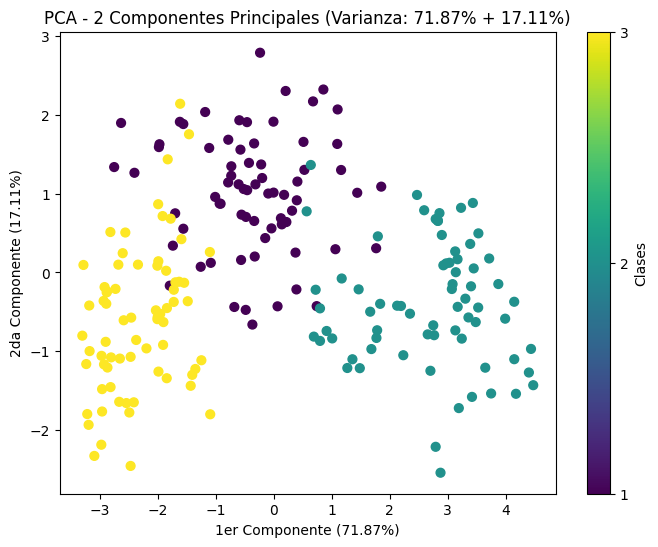

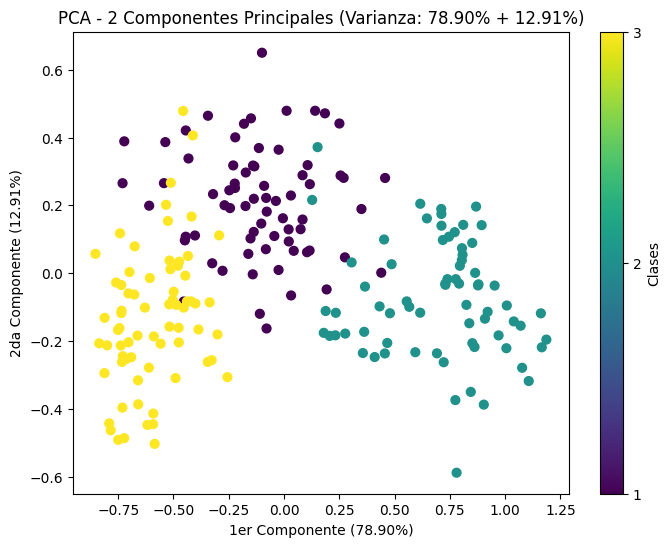

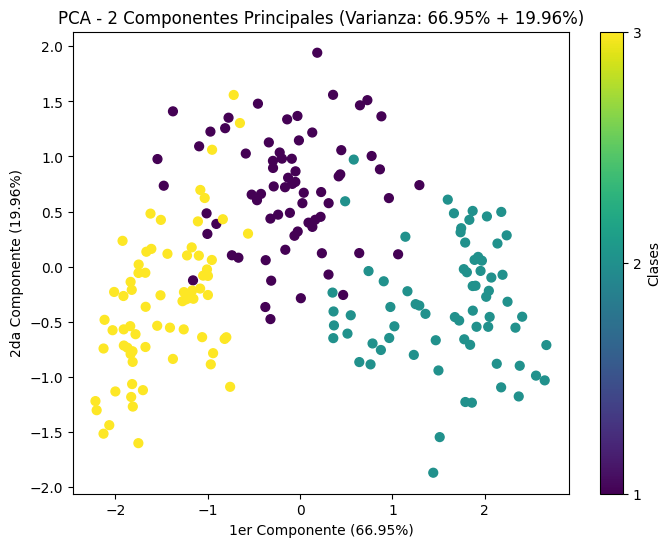

In [16]:
bestScaler = None
bestVariance = 0.0
for scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=seed))
    ])

    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=40, cmap='viridis')
    plt.title('PCA - 2 Componentes Principales (Varianza: {:.2%} + {:.2%})'.format(explained_variance[0], explained_variance[1]))
    plt.xlabel('1er Componente ({:.2%})'.format(explained_variance[0]))
    plt.ylabel('2da Componente ({:.2%})'.format(explained_variance[1]))
    cbar = plt.colorbar(scatter, ticks=[1, 2, 3])
    cbar.set_label('Clases')
    plt.show()

    if sum(explained_variance) > bestVariance:
        bestVariance = sum(explained_variance)
        bestScaler = scaler

Observando estos gráficos se puede ver como el mejor Scaler para este modelo es el MinMaxScaler(), debido que obtienene la mayor varianza explicada total entre la suma de las dos componentes, 91.81%. Esto implica, en otras palabras, que es el que menos información pierde.

In [17]:
# Visualización 3D de PCA

"""
for scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):
    pipeline = Pipeline([
        ('scaler', scaler),  # Siempre escalar antes de PCA
        ('pca', PCA(n_components=3, random_state=seed))
    ])

    # Transformar
    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']

    # Visualizar
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    scatter = ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],
        c=y,
        s=40,
        cmap='viridis',
    )

    ax.set(
        title="Primeras tres componentes PCA ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100 + pca.explained_variance_ratio_[1]*100 + pca.explained_variance_ratio_[2]*100),
        xlabel="1er Componente ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100),
        ylabel="2da Componente ({:.2f}%)".format(pca.explained_variance_ratio_[1]*100),
        zlabel="3ra Componente ({:.2f}%)".format(pca.explained_variance_ratio_[2]*100)
    )

    # Leyenda
    legend1 = ax.legend(
        scatter.legend_elements()[0],
        target_names,
        loc="upper right",
        title="Clases"
    )
    ax.add_artist(legend1)

    plt.show()
"""

'\nfor scaler in (StandardScaler(), MinMaxScaler(), RobustScaler()):\n    pipeline = Pipeline([\n        (\'scaler\', scaler),  # Siempre escalar antes de PCA\n        (\'pca\', PCA(n_components=3, random_state=seed))\n    ])\n\n    # Transformar\n    X_reduced = pipeline.fit_transform(X)\n    pca = pipeline.named_steps[\'pca\']\n\n    # Visualizar\n    fig = plt.figure(figsize=(8, 6))\n    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)\n\n    scatter = ax.scatter(\n        X_reduced[:, 0],\n        X_reduced[:, 1],\n        X_reduced[:, 2],\n        c=y,\n        s=40,\n        cmap=\'viridis\',\n    )\n\n    ax.set(\n        title="Primeras tres componentes PCA ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100 + pca.explained_variance_ratio_[1]*100 + pca.explained_variance_ratio_[2]*100),\n        xlabel="1er Componente ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100),\n        ylabel="2da Componente ({:.2f}%)".format(pca.explained_variance_ratio_[1]*100)

## *__3 . Seleccionar mejor técnica de clustering__*

Ya seleccionado el mejor scaler y haber transformado los datos a 2D, se aplicarán las técnicas de clustering explicadas en clase: K-Means, Hierarchical Clustering/Dendrogramas, DBSCAN


### *__3.1 . K-means__*

Realizar el método del codo para comprobar cual es el número de clusters adecuado para este modelo

In [18]:
from sklearn.cluster import KMeans
pipeline = Pipeline([
    ('scaler', bestScaler),
    ('pca', PCA(n_components=2))
])

X_pca = pipeline.fit_transform(X)
pca = pipeline.named_steps['pca'] 

Text(0, 0.5, 'Intra-cluster (inertia)')

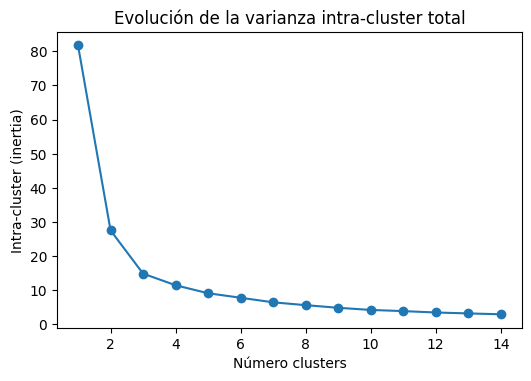

In [19]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = seed
    )
    modelo_kmeans.fit(X_pca)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')

Para elegir cual es el número de clusters óptimo hay que elegir el del punto "codo", es decir, cuando se empienza a aplanar la curva. En este caso es 3, como ya se sabía. 

Text(0, 0.5, 'Media índices silhouette')

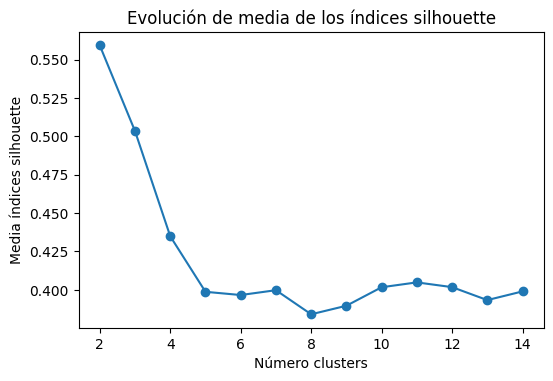

In [20]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
from sklearn.metrics import silhouette_score
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')

cluster,0,1,2
grupo_real,,,
1,2,10,58
2,61,0,9
3,0,67,3


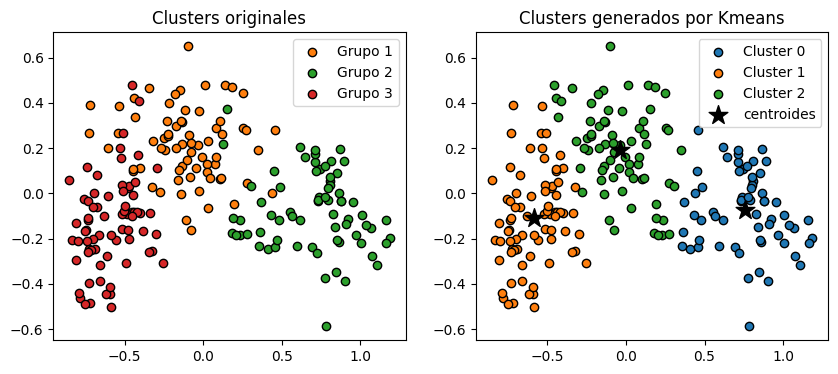

In [21]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

modelo_kmeans = KMeans(n_clusters=3, n_init=20, random_state=seed)
modelo_kmeans.fit(X=X_pca)
y_predict = modelo_kmeans.predict(X=X_pca)

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_pca[y == i, 0],
        y = X_pca[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_pca[y_predict == i, 0],
        y = X_pca[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'])

Precisión obtenida: 89,04%

### *__3.2 . Hierarchical Clustering/Dendrogramas__*

In [22]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

In [23]:
modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_pca)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_pca)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_pca)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

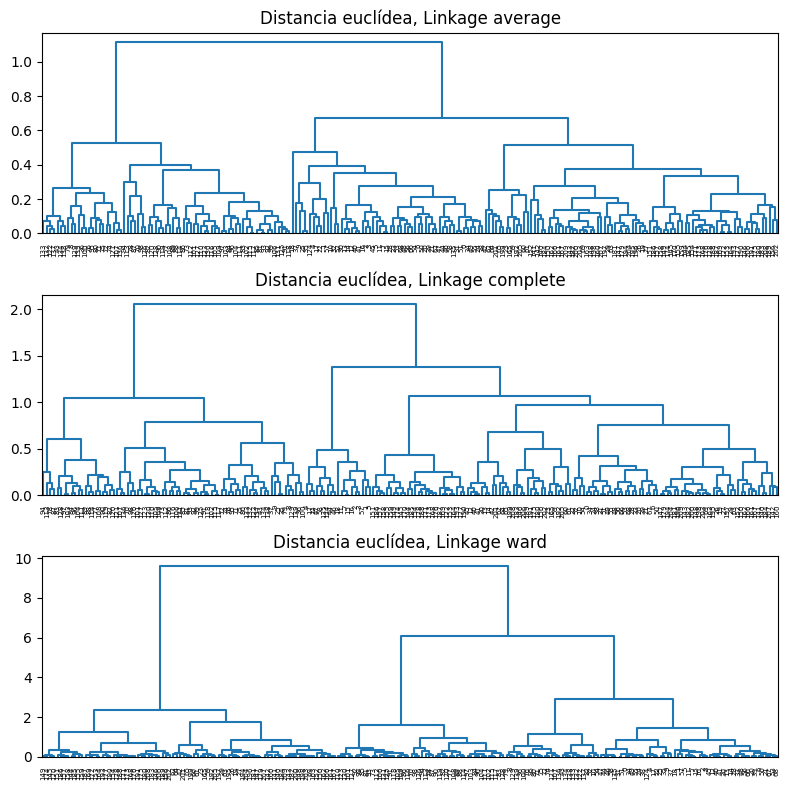

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=data.index)

plot_dendrogram(modelo_hclust_average, labels=X_pca.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=X_pca.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=X_pca.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout()

Text(0, 0.5, 'Media índices silhouette')

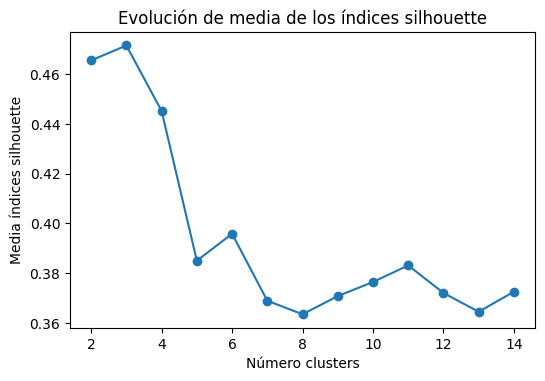

In [25]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        metric   = 'euclidean',
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette')

In [26]:
# Modelo final
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    n_clusters = 3
)
modelo_hclust_ward.fit(X=X_pca)

AgglomerativeClustering(n_clusters=3)

Número óptimo de clusters: 2
Altura de fusión óptima: 6.09


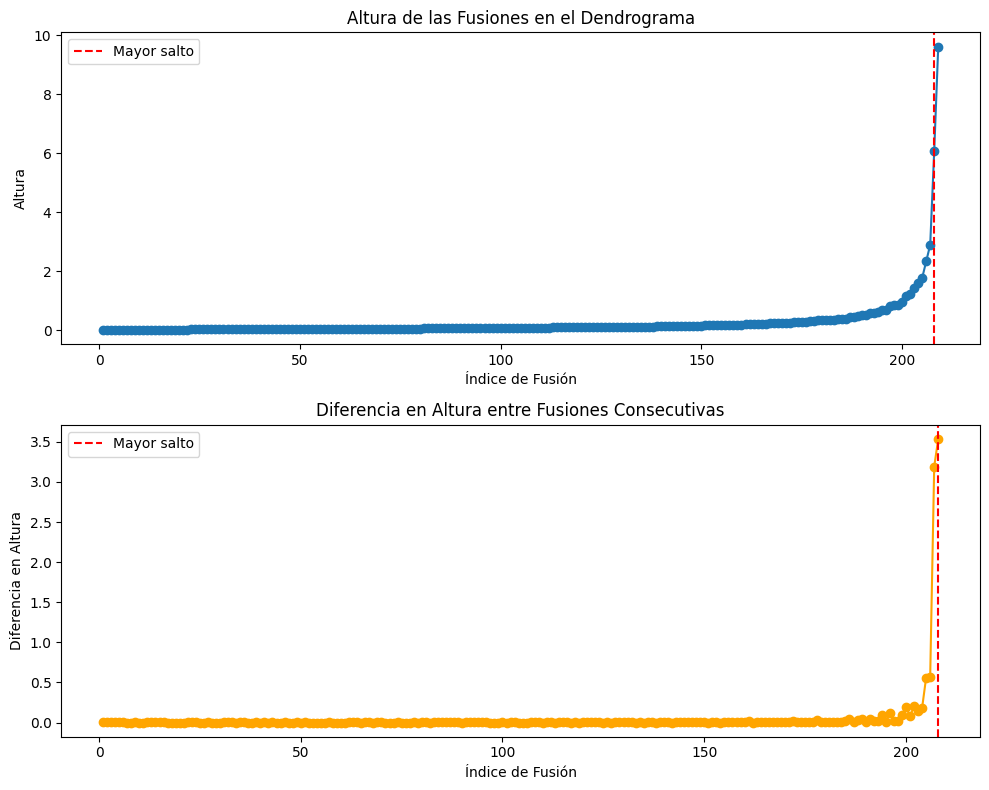

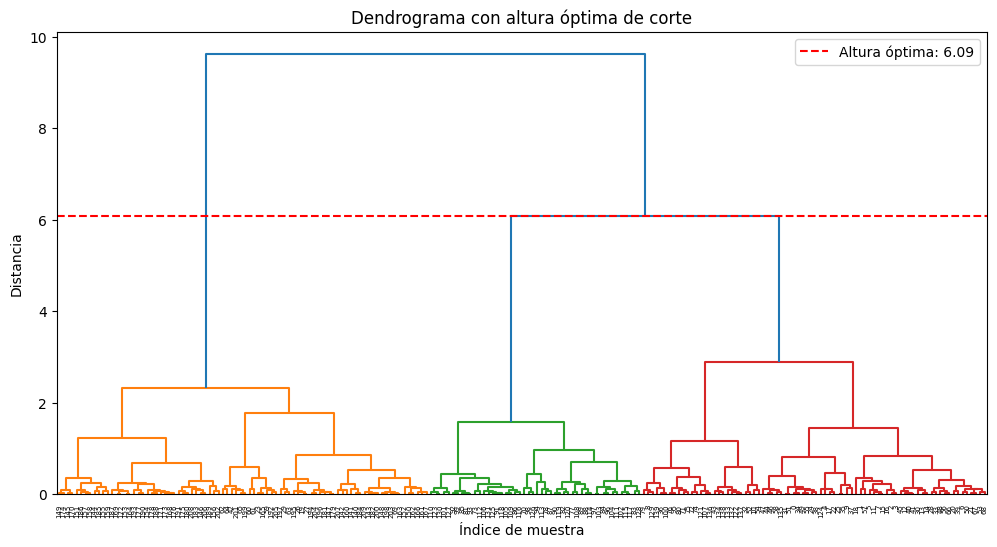

In [27]:
import scipy.cluster.hierarchy as sch

# Calculamos la matriz de enlace con linkage 'ward'
Z = sch.linkage(X_pca , method='ward')

# Extraemos las alturas de fusión
heights = Z[:, 2]  # La tercera columna contiene las alturas de fusión

# Calculamos las diferencias entre alturas consecutivas
diffs = np.diff(heights)

# Índice donde ocurre el mayor salto en altura
idx_max_jump = np.argmax(diffs)

# Número óptimo de clusters basado en el mayor salto
n_clusters_optimo = len(heights) - idx_max_jump 

# Altura de fusión en el mayor salto
altura_optima = heights[idx_max_jump]

print(f"Número óptimo de clusters: {n_clusters_optimo}")
print(f"Altura de fusión óptima: {altura_optima:.2f}")

# Ahora ploteamos la información

# Graficamos la altura de fusión y su incremento
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de las alturas de fusión
ax[0].plot(range(1, len(heights) + 1), heights, marker='o', linestyle='-')
ax[0].set_title("Altura de las Fusiones en el Dendrograma")
ax[0].set_xlabel("Índice de Fusión")
ax[0].set_ylabel("Altura")
ax[0].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[0].legend()

# Gráfico del incremento en altura
ax[1].plot(range(1, len(diffs) + 1), diffs, marker='o', linestyle='-', color='orange')
ax[1].set_title("Diferencia en Altura entre Fusiones Consecutivas")
ax[1].set_xlabel("Índice de Fusión")
ax[1].set_ylabel("Diferencia en Altura")
ax[1].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[1].legend()

plt.tight_layout()
plt.show()

# Graficamos el dendrograma
plt.figure(figsize=(12, 6))
sch.dendrogram(Z, color_threshold=altura_optima)  # Coloriza los clusters a esa altura
plt.axhline(y=altura_optima, color='r', linestyle='dashed', label=f'Altura óptima: {altura_optima:.2f}')
plt.title("Dendrograma con altura óptima de corte")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.legend()
plt.show()

### *__3.3 . DBSCAN__*

Text(0.5, 1.0, 'Clusterings generados por DBSCAN con eps=0.2 y min_samples=5')

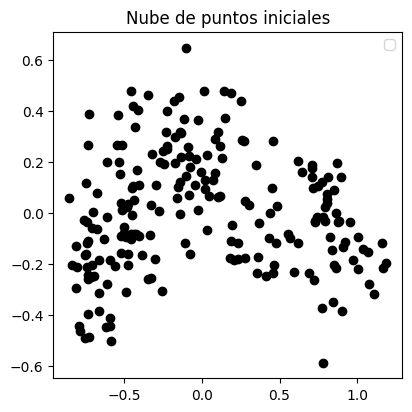

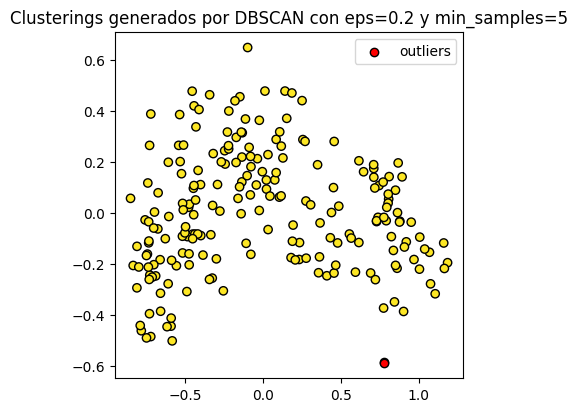

In [46]:
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_pca.iloc[:, 0],
    y = X_pca.iloc[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales');

# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_pca)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_pca.iloc[:, 0],
    y = X_pca.iloc[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_pca.iloc[labels == -1, 0],
    y = X_pca.iloc[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN con eps=0.2 y min_samples=5')

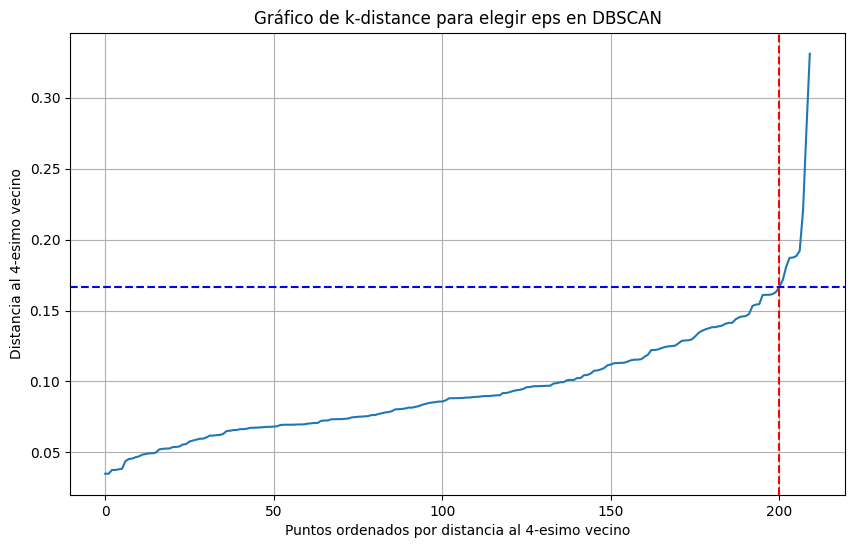

x_point=200 y_value=0.16673162014672105


In [37]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

min_samples = 5

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_pca)
distances, indices = nn.kneighbors(X_pca)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1], axis=0)

x_point = 200
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples-1))
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples-1))
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--')

# Dibujar la línea horizontal correspondiente en el eje Y
plt.axhline(y=y_value, color='b', linestyle='--')

plt.grid(True)
plt.show()

print(f'{x_point=} y_value={y_value}')

Número de clusters encontrados: 3
Número de outliers encontrados: 78


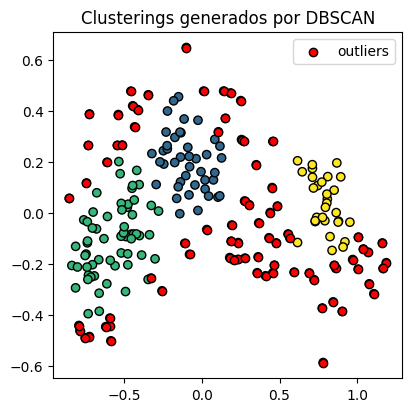

In [ ]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = y_value,
    min_samples  = 20,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_pca)
    
# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_pca.iloc[:, 0],
    y = X_pca.iloc[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_pca.iloc[labels == -1, 0],
    y = X_pca.iloc[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN con')

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')





## *__4 . Análisis__*